In [ ]:
#Installing dependent libraries

!pip install opendatasets
!pip install pandas
!pip install -q kaggle
!pip install tensorflow
!pip install keras

In [ ]:
#Check tensorflow version for incompatibilities
print(tf.__version__)

2.18.0


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Insert your folder path for zipped dataset here
zip_file_path = r"/content/drive/MyDrive/TAMU Junior Year/AI4All/AI4ALL-Class-16-Group-2/ASL Dataset.zip"

In [ ]:
#switching to dataset directory
!unzip  "{zip_file_path}" -d /content/ASLDataset

Archive:  /content/drive/MyDrive/TAMU Junior Year/AI4All/AI4ALL-Class-16-Group-2/ASL Dataset.zip
replace /content/ASLDataset/ASL_Alphabet_Dataset/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%cd /content/ASLDataset/ASL_Alphabet_Dataset
!ls

/content/ASLDataset/ASL_Alphabet_Dataset
asl_alphabet_test  asl_alphabet_train


/content/ASLDataset/ASL_Alphabet_Dataset/asl_alphabet_test


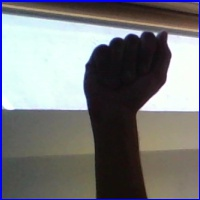

In [ ]:
%cd asl_alphabet_test

#testing dataset
from IPython.display import Image
Image('A_test.jpg')

In [ ]:
%cd ../asl_alphabet_train

#initialize class names for classification
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'other']
#label class names with numbers corresponding to each class in a dictionary format (0-26)
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

#defining image size in dataset
IMAGE_SIZE = (200, 200)

#print class names with corresponding numerical label
print(class_names_label)

/content/ASLDataset/ASL_Alphabet_Dataset/asl_alphabet_train
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'other': 26}


In [ ]:
#Importing library dependencies
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tqdm import tqdm
import shutil
from math import ceil

In [ ]:
#Merges del, nothing, and space folder in "other" folder

# Define valid image extensions
VALID_IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}

if not os.path.exists('./other'):
  os.makedirs('./other')

if (os.path.exists('./nothing')):
  for image in os.listdir('./nothing'):
    s = os.path.join('./nothing', image) #gets path of image in nothing folder

    if os.path.isfile(s) and os.path.splitext(image)[1].lower() in VALID_IMAGE_EXTENSIONS:
        d = os.path.join('./other', image)  #makes path of image in other folder
        shutil.move(s, d)  #moves image in nothing folder into other folder

if (os.path.exists('./space')):
  for image in os.listdir('./space'):
    s = os.path.join('./space', image) #gets path of image in space folder
    if os.path.isfile(s) and os.path.splitext(image)[1].lower() in VALID_IMAGE_EXTENSIONS:
        d = os.path.join('./other', image)  #makes path of image in other folder
        shutil.move(s, d)  #moves image in space folder into other folder

if (os.path.exists('./del')):
  for image in os.listdir('./del'):
    s = os.path.join('./del', image) #gets path of image in del folder
    if os.path.isfile(s) and os.path.splitext(image)[1].lower() in VALID_IMAGE_EXTENSIONS:
        d = os.path.join('./other', image)  #makes path of image in other folder
        shutil.move(s, d)  #moves image in del folder into other folder

In [ ]:
#Delete empty folder paths
folder_paths = ['./nothing', './del', './space']

for folder_path in folder_paths:
  if os.path.exists(folder_path) and os.path.isdir(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
  else:
    print(f"Folder not found or not a directory: {folder_path}")
%ls

Folder not found or not a directory: ./nothing
Folder not found or not a directory: ./del
Folder not found or not a directory: ./space
A/  C/  E/  G/  I/  K/  M/  O/      P/  R/  T/  V/  X/  Z/
B/  D/  F/  H/  J/  L/  N/  other/  Q/  S/  U/  W/  Y/


In [ ]:
#Renaming all images in other to other1-other{n}...
folder_path = './other'
image_name_prefix = 'other'

#Normalize folder_path to ensure no trailing slash
folder_path = os.path.normpath(folder_path)

#lists all images in the folder
images = os.listdir(folder_path)

#Rename each item
for i, image in enumerate(images, start=1):
  #Get current image's file path
  old_path = os.path.join(folder_path, image)

  #Construct new name w/ numerical ordering and file extension
  new_name = f"{image_name_prefix}{i}.jpg"
  new_path = os.path.join(folder_path, new_name)

  #Rename image
  if not os.path.exists(new_path):
        os.rename(old_path, new_path)

print(f"Renamed {len(images)} images in the other folder")

Renamed 16937 images in the other folder


In [ ]:
#function used to train & test data
def collectData():
  img_paths = []
  labels = []


  for folder in os.listdir("./"): #loop through all directories in current file path
    label = class_names_label[folder] #folder names are same as class_names dictionary (will return a number) --> i.e. class_names_label["A"] = 0

    #Iterate through each image in our folder
    for file in os.listdir(os.path.join("./", folder)):
      img_path = os.path.join(os.path.join("./", folder), file)

      img_paths.append(img_path) #append image to list
      labels.append(label) #append label of imgae to list

  return img_paths, labels

#put all image file paths in image_paths list and all corresponding labels in labels list
image_paths, labels = collectData()

In [ ]:
from sklearn.model_selection import train_test_split

#stratify on labels b/c far more data in other folder than the rest of the classes (also set random state during data testing)
img_train, img_test, label_train, label_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

print(len(img_train), len(label_train))
print(len(img_test), len(label_test))

178459 178459
44615 44615


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Create a custom data generator
def custom_data_generator(image_paths, labels, batch_size, datagen, target_size=(200, 200)):
    while True:  # Infinite loop to keep generating batches
        indices = np.random.permutation(len(image_paths))  # Shuffle data

        for i in range(0, len(image_paths), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_image_paths = [image_paths[j] for j in batch_indices]
            batch_labels = [labels[j] for j in batch_indices]

            batch_images = []
            for img_path in batch_image_paths:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error loading image: {img_path}")
                    continue  # Skip invalid images
                img = cv2.resize(img, target_size)  # Resize to the desired shape (e.g., 200x200)
                batch_images.append(img)

            # If there are no valid images in the batch, skip this iteration
            if len(batch_images) == 0:
                continue

            # Convert the list of images to a NumPy array
            batch_images = np.array(batch_images)
            batch_images = np.expand_dims(batch_images, axis=-1)  # Add channel dimension
            batch_images = batch_images.astype('float32') / 255.0  # Normalize the images

            # Apply data augmentation using flow
            augmented_images = datagen.flow(batch_images, batch_size=batch_size, shuffle=False)

            # Yield augmented images and corresponding labels
            for augmented_batch_images in augmented_images:
                yield augmented_batch_images, np.array(batch_labels)  # Yield the batch of images and labels

# Step 2: Define your ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Fill missing pixels after transformations
)

batch_size = 32
target_size = (200, 200)

# Create the custom generator
train_generator = custom_data_generator(img_train, label_train, batch_size, datagen, target_size)
test_generator = custom_data_generator(img_test, label_test, batch_size, datagen, target_size)


**Attempt at using tf.data API to have lazy pre-processing FAILED**

In [ ]:
#Use tensor flow lazy pre-processing (tf.data) in order to only load required data onto RAM

# Function to load and preprocess images
def load_image(image_path, label):
  image_path = image_path.numpy().decode('utf-8')  # Convert to string
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as grayscale
  img = cv2.resize(img, (200,200))
  img = img.astype('float32') / 255.0  # Normalize the image
  #img = np.expand_dims(img, axis=-1)  # Add channel dimension
  return img, label

def preprocess_image(image_path, label):
  img, label = tf.py_function(
      load_image,
      inp=[image_path, label],
      Tout=(tf.float32, tf.int32))

  img.set_shape((200, 200, 3)) #define grayscale image numpy array shape
  return img, label

# Create a dataset from a list of image paths and labels
def create_dataset(image_paths, labels, batch_size=32):
    # Create a TensorFlow dataset from image paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels)) #uses lazy processing to save memory

    #Map the load_image function to the dataset (to load and preprocess images)
    image_ds = path_ds.map(preprocess_image)

    # Shuffle, batch, and prefetch for performance
    image_ds = image_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    #image_ds = image_ds.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)

    return image_ds


# Create the TensorFlow datasets for training & testing
train_dataset = create_dataset(img_train, label_train)
test_dataset = create_dataset(img_test, label_test)

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, verbose=1)

End of tf.data API attempt

**Attempt to segment image arrays to prevent RAM overload below:**

In [ ]:
#loop through each image path, open and resize the image, then append them to numpy arrays to train keras CNN with
imageTrainList = []
labelTrainList = []

#Split data in 40,000 image segments to prevent overwhelming CPU
for i in range(40001):
  img_path = img_train[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTrainList.append(image)
  labelTrainList.append(label_train[i])

In [ ]:
#segment 2
for i in range(40001,80001):
  img_path = img_train[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTrainList.append(image)
  labelTrainList.append(label_train[i])

In [ ]:
#segment 3
for i in range(80001,120001):
  img_path = img_train[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTrainList.append(image)
  labelTrainList.append(label_train[i])

In [ ]:
#segment 4
for i in range(120001,140001):
  img_path = img_train[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTrainList.append(image)
  labelTrainList.append(label_train[i])

In [ ]:
#segment 5
for i in range(140001,len(img_train)):
  img_path = img_train[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTrainList.append(image)
  labelTrainList.append(label_train[i])

In [ ]:
#Convert training images to numpy arrays for keras usage
imageTrainList = np.array(imageTrainList, dtype='float32')
labelTrainList = np.array(labelTrainList, dtype='int32')

In [ ]:
#Shuffle images for better training (standard procedure)
imageTrainList, labelTrainList = shuffle(imageTrainList, labelTrainList, random_state=42)

print("Training Image & Label array conversion successful!")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( #automatic data augmentation
    rescale=1./255,  # Normalize pixel values to range [0, 1]
    rotation_range=40,  # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Random shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill newly created pixels
)



In [ ]:
# Using datagenerator, generate batches of data from numpy array lists
train_generator = datagen.flow(imageTrainList, labelTrainList, batch_size=32)

In [ ]:
#Do the same w/o shuffling for testing
imageTestList = []
labelTestList = []

for i in range(len(img_test)):
  img_path = img_test[i]
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, IMAGE_SIZE)

  imageTestList.append(image)
  labelTestList.append(label_test[i])

In [ ]:
#Convert training images to numpy arrays for keras usage
imageTestArray = np.array(imageTestList, dtype='float32')
labelTestArray = np.array(labelTestList, dtype='int32')

print("Testing Image & Label array conversion successful!")

**End of image segmentation attempt**

In [ ]:
#Creating CNN with keras
#This CNN has:
#1 hidden layer
#Input layer = convolution layer -> also followed by MaxPoolingLayer
#Hidden layer of another convolution layer & MaxPoolingLayer
#flatten outputs to reduce the number of features and have an output layer consisting of a dense relu layer & dense softmax layer
model = tf.keras.models.Sequential([
    # Input layer (no need to specify input_shape if it's the first layer)
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(200, 200, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),  # Corrected pooling layer
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),  # Corrected pooling layer
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),  # Corrected pooling layer
    tf.keras.layers.Dropout(0.4),

    # Flatten the feature maps before passing to dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output layer with softmax activation for classification
    tf.keras.layers.Dense(27, activation='softmax')  # Assuming 27 classes
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary();

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)                  │ (None, 200, 200, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 200, 200, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_87 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_88 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 80000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │      40,960,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,260,795 (157.40 MB)

 Trainable params: 41,260,795 (157.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Check that image & label shape are as expected
for images, labels in train_dataset.take(1):
    print(images.shape)  # Expected: (batch_size, 200, 200, 1)
    print(labels.shape)  # Expected: (batch_size,)
    print(labels.dtype)

(32, 200, 200, 3)
(32,)
<dtype: 'int32'>


In [ ]:
# Test the model with one batch and check if shape of output is expected
for images, labels in train_dataset.take(1):
    predictions = model(images)  # Forward pass
    print(predictions.shape)  # Should print: (32, 27) if output layer has 27 classes

(32, 27)


In [ ]:
#define keras callback functions to stop early & reduce training when notcing no increase in accuracy

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [ ]:
# Manually check one batch of images and labels from the generator
for images, labels in custom_data_generator(image_paths, labels, batch_size=32, datagen=datagen, target_size=(200, 200)):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break  # Exit after one batch

Images shape: (32, 200, 200, 1)
Labels shape: (32,)


In [ ]:
batch_size = 32
epoch_steps = ceil(len(img_train) / batch_size)
validation_steps = ceil(len(img_test) / batch_size)
#testing = model.fit(train_generator, epochs=30, validation_data=test_generator, steps_per_epoch=(epoch_steps), callbacks=[early_stopping, reduce_learning_rate], verbose=1)
testing = model.fit(train_generator, epochs=30, validation_data=test_generator, steps_per_epoch=9, validation_steps=10, callbacks=[early_stopping, reduce_learning_rate], verbose=1)

AttributeError: 'NumpyArrayIterator' object has no attribute 'shape'

In [ ]:
for data in test_generator:
    print(data)  # This should print batches of images and labels
    break

(array([[[[0.00044598],
         [0.00044598],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044598],
         [0.00043895]],

        [[0.00044598],
         [0.00044598],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044598],
         [0.00043374]],

        [[0.00044598],
         [0.00044598],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044137],
         [0.00043267]],

        ...,

        [[0.00045908],
         [0.00044625],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044598],
         [0.00044598]],

        [[0.00045387],
         [0.00044598],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044598],
         [0.00044598]],

        [[0.00044867],
         [0.00044598],
         [0.00044598],
         ...,
         [0.00044598],
         [0.00044598],
         [0.00044598]]],


       [[[0.0004306 ],
         [0.0004306 ],
         [0.0

In [ ]:
model.save('ASLClassifier.h5')